<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/wound_care_emergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Unsupervised, Generative Knowledge Graphs
  Produce enormous graph networks, based on time-series correlation between topics
  1.  Get an OpenAi token, save to a file and import, ex. 'openai_key'
  2.  Input list of seed topics that you want expanded upon
  3.  Experiment with new variations in OpenAi questioning format

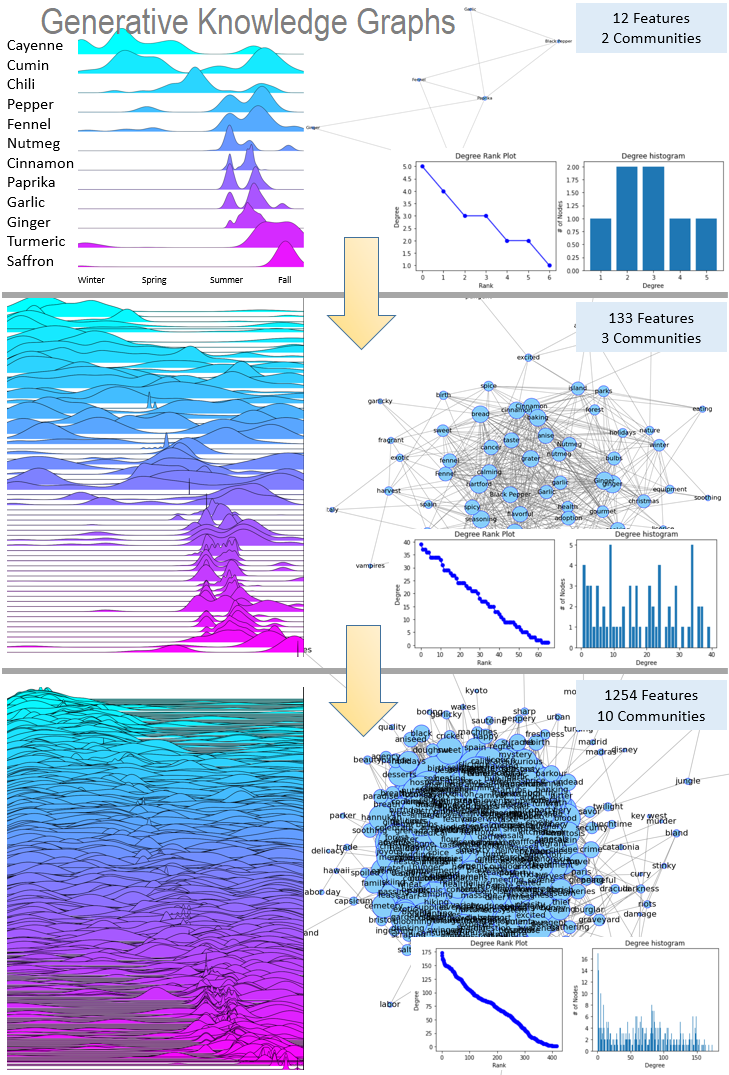

## installs

In [ ]:
!pip install pytrends
!pip install joypy

# install openai
!pip install openai

# install dgl
!pip install dgl

# jupyter viz
!pip install visJS2jupyter

# install transformers
!pip install transformers -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## imports

In [ ]:
import numpy
import pandas 
import re
import string
import os

import time 
from difflib import SequenceMatcher

from pytrends.request import TrendReq
from pytrends         import dailydata
import pytrends
from operator         import index

import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn 
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import openai

import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import visJS2jupyter.visualizations as visualizations

# supply openai api key via file 
openai.api_key = open('openai_key').read()
#openai.api_key = 'rrtt'

# LM transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed

# pytorch
import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor)

import gc
gc.collect

# import BLOOM models
# model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-1b3", use_cache=True)
# tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-1b3")

# model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-350m", use_cache=True)
# tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-350m")


<function gc.collect(generation=2)>

## seed config

In [180]:
### Generative Seeds, topics and question formatting to feed to OpenAi

# dispaly neo4j cypher commands for learning and debug
cypher_echo = True

# seed topics
# topics = ['Type 1 diabetes', 'Type 2 diabetes', 'Cardiovascular disease', 'Rheumatoid arthritis'
#         ,'Coronary artery disease', 'Multiple sclerosis', 'Stroke', 'Clots', 'Hemorrhage', 'Epilepsy '
#         ,'Arthritis', 'Cancer', 'High blood pressure', 'Obesity', 'Alzheimer', 'Hospice', 'Tooth decay']

# decapitalized
topics = ['diabetes', 'cardiovascular disease', 'rheumatoid arthritis'
         ,'coronary artery disease', 'multiple sclerosis', 'stroke', 'clots', 'hemorrhage', 'epilepsy '
         ,'arthritis', 'cancer', 'high blood pressure', 'obesity', 'alzheimer', 'tooth decay']

context = ['elderly', 'diabetic', 'pregant', 'man', 'women']

perspective = ['texas', 'california', 'new york', 'mid west', 'south', 'florida']

# topics = ['diabetic ulcers', 'pressure ulcers', 'venousstasious ulcers'
#         , 'arterial', 'trauma wound', 'soft tissue necrousis', 'heart condition','healing']

relatives = [ 'diet', 'activities', 'regional'
          , 'holidays', 'seasonal'] 

# relatives = ['life style choices', 'diet', 'behavior', 'activities'
#          , 'holidays', 'yearly events', 'monthly', 'seasonal'] 


# request object



#req_obj = ['concepts', 'styles', 'cities', 'emotions','concerns', 'attitudes', 'alternatives', 'regions'
#         , 'life events', 'yearly events', 'life style', 'behaviors', 'memories', 'mistakes', 'goals'
#         , 'holidays']


regex = re.compile('[^a-zA-Z ]')

### Generative Bounds, prescribe factors needed to control generative iterations

# connection strenth minimum boost, base on standard deviation
std_factor = .3
std_factor = 0
pop_threshold = 0

# batch size
batch_size = 30

# max fetch
max_fetch = 10

# max relationship strength
max_similarity = 0.95

## helper functions
  1. get_trend_frame(topics, years): 
          returns a dataframe of topic trends
  2. stack_nodes_vertically(df_features): 
          form graph source/target relationships
  3. build_node_labels(df_flat): 
          generate labels based on time interval
  4. get_ridgeplot(df_flat):
          visualize temporal attributes
  5. get_openai_response(question):
          using standard format, prompt openai for new top lists
  6. get_pairwise_similarity(df_features, topics, std_factor): 
          for combinations of topics, get temporal correlation
  7. swap_tokens(chk_topics, new_topics):
          replace any duplicates between existing and new features
  8. build_graph_network(df_slice):
          buiod graph
  9. get_openai_generated_topics(topic, obj):
          form openAi question given generative seeds
  10. get_related_topics(df):
          mechanism for enhancing graph based on generative seeds
  11. get_graph_degree(G):
          get graph statisitcs for feeding into downstream predictive models

In [ ]:
### 1. for a given list of topics, return dataframe of interests from pytrend
def get_trend_frame(topics, years, state_code):

  # batch management
  batch_counter = 0
  batch_idx = 0
  fetch_idx = 0

  # initialize return frame
  df_total = pandas.DataFrame()

  # for each provided TOPIC
  for topic in topics:

    if fetch_idx > max_fetch:
      print('hit local max of %d' % (fetch_idx))
      break

    # prevent saturation of api endpoint
    if batch_counter > batch_size:
      print('')
      batch_idx+=1
      print('completed retrieval of batch %d - %d rows of %d' % (batch_idx, round(batch_idx * batch_size), len(topics) ))
      batch_counter=0
      time.sleep(30)


    # pytrend request
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[topic]
                         ,geo=( "US-%s" % (state_code) )
                         ,timeframe=( 'today %s-y' % (years)))
    
    # load trend request
    df = pytrend.interest_over_time()

    # counters
    batch_counter+=1
    fetch_idx+=1

    try:

      # add column for new topic
      df_total[topic] = df[topic]


    except:
      print('failed to add topic - %s ' % (topic))


  # drop nans
  df_total = df_total.dropna()

  # return standard frame
  return df_total

In [ ]:
### 2. for each topic and interval of time, stack a vertical dataframe of value counts
def stack_nodes_vertically(df_features):

  # initialize buffers resources
  df_stk=pandas.DataFrame()
  globalst=[]

  # for each feature
  for col in df_features:                      # topic

      # for each time interval
      for val in df_features.index.weekofyear: # weeknum

          try:

            # time sensitive
            fs_val = df_features[col][val]       # full spectrum
                
            if fs_val > pop_threshold:

              # iterate through each instance of max bin occurence, determining number of weeks written
              for x in range(0,int(abs(fs_val) * 100)):
                
                  # build buffer list
                  lst = [val, val, col]
                  globalst.append(lst)

            else:
                  # build buffer list
                  lst = [val, None, None]
                  globalst.append(lst)

          except Exception as e: # work on python 3.x
              print(col)              
              print(val)
              print(fs_val)
              print('Failed to upload to ftp: '+ str(e))

  # materialize vertically flattened
  df_flat = pandas.DataFrame(globalst
                            ,columns=['WeekNum'
                            ,'WeekNum_Rct'
                            ,'Flower_Tot'])
  
  return df_flat

In [ ]:
### 3. prefix ridgemap/joyplot labels with weeknum average
def build_node_labels(df_flat):
  
  # get all distinct nodes
  df_stats = df_flat.groupby('Flower_Tot').agg(['mean', 'count']).reset_index()

  # rename columns to node labels
  df_stats.columns = [' '.join(col).strip() for col in df_stats.columns.values]

  # sort by average time interval
  df_stats = df_stats.sort_values(by='WeekNum mean',ascending=True)

  # include average into node label
  df_stats['Name'] = ( ( df_stats['WeekNum mean'] * 100) + 1000).astype('int').astype('str') + ' '+ df_stats['Flower_Tot']

  # update flattened node space with averaged names
  for index, row in df_stats.iterrows():
      df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])

  return df_flat

In [ ]:
### 4. display ridgeplot of time frame, for 
def get_ridgeplot(df_flat):


  # colors = ["lightgray", "lightgreen", "yellowgreen", "lightgreen", "lightgray"]
  # colors = ["white", "lightgray", "lightgreen", "lightgray", "white"]
  colors = ["white", "#6DC14C", "white"]  
  cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

  # configure and build ridgeplot
  fig, axes = joypy.joyplot(df_flat
                            , column=['WeekNum', 'WeekNum_Rct']
                            , by='Flower_Tot'
                            , overlap=1.2
                            , fill=True
                            , figsize=(22,22)
                            , x_range = [0,52]
                            , colormap=cmap1
                            # , colormap=cm.YlGn                         
                            , ylim='own'
                          )


  # write ridgeplot
  # plt.savefig(('/content/drive/MyDrive/frank_jj_%s.png' % (len(df_flat))) )
  # plt.savefig(my_path + '/Sub Directory/graph.png')


  # plot
  plt.show()

In [ ]:
### 5. send openai question, receive response
def get_openai_response(question):

    # format open au request
    response = openai.Completion.create(
                      engine="text-davinci-001",
                      prompt=question,
                      temperature=.5,
                      max_tokens=250,
                      top_p=1,
                      frequency_penalty=50,
                      presence_penalty=0 )

    # parse and process open ai response
    response_choices = response["choices"]

    # replace blanks
    response = response_choices[0]["text"].strip('\n')

    return response

In [ ]:
def swap_tokens(chk_topics, new_topics):

  buffer_lst = []

# for each graphed topics
  for chk_topic in chk_topics:

    buffer_lst.append(chk_topic)


  for new_topic in new_topics:

    # token validation checks

      new_topic_split = new_topic.split()
    
    # 1. check that not preceeded by short word
      if len(new_topic_split[0]) < 3:

        try:
          new_topic = new_topic_split[1]
        except:
          pass
        

      buffer_lst.append(new_topic)


  return buffer_lst


In [ ]:
def get_pairwise_similarity(df_features, topics, std_factor):

  # pair wise correlation / similarity
  c = df_features.corr().abs()

  # flatten and sort
  so = c.unstack().sort_values(kind="quicksort")

  # remove low connections
  min_connection_strength = so.mean() + ( std_factor * so.std() )
  min_connection_cutoff = len(so) - len(so[so > min_connection_strength])

  # turn to frame
  df_slice = so[min_connection_cutoff:-len(topics)].to_frame()

  df_slice.reset_index(inplace=True)

  df_slice.columns = ['source','target','weight']

  return df_slice

In [ ]:
def build_graph_network(df_slice):

  # build graph 
  G = nx.from_pandas_edgelist(df_slice
                            ,'source'          # parent
                            ,'target'          # child
                            , ['weight'])      # relationship


  # define plot area
  plt.figure(3,figsize=(22,22)) 

  # calc degrees per node
  d = dict(G.degree)

  # visualize graph 
  nx.draw(G         
      ,nx.kamada_kawai_layout(G)               
      ,with_labels=True
      ,edge_color='gray'
      ,node_color='#6DC14C'
      ,node_size=[v * 700 for v in d.values()]
      ,font_size=22)
  
  ax = plt.gca() # to get the current axis
  ax.collections[0].set_edgecolor("blue")

  return G

In [ ]:
def get_related_topics(df, context, perspective):

  lst_buffer = []
  graph_topics = list(df['source'].unique())

  # batch management
  batch_counter = 0
  batch_idx = 0
  fetch_idx = 0

  # TOPICS
  for graph_topic in graph_topics:

    # if match is hit
    if fetch_idx > max_fetch:
      print('hit local max of %d' % (fetch_idx))
      break

    # RELATIVE ITERATOR 
    for obj in relatives:

      # prevent saturation of api endpoint
      if batch_counter > batch_size:
        print('')
        batch_idx+=1
        print('completed openai retrieval of batch %d - %d rows of %d' % 
              (batch_idx, round(batch_idx * batch_size)
              , len(graph_topics) * len(relatives) ))
        batch_counter=0
        time.sleep(30)

      topic_list = get_openai_generated_topics(graph_topic, obj, perspective)

      print(topic_list)

      for topic in topic_list:

        topic = topic.translate(string.punctuation)
        topic = re.sub(r'[^\w\s]','',topic)

        if len(topic) < 10 and len(topic) > 4:

          lst_buffer.append(topic)
        fetch_idx+=1
      
      # counters
      batch_counter+=1
      
      print(lst_buffer)
    
  return lst_buffer

In [ ]:
def get_graph_degree(G):
  degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
  dmax = max(degree_sequence)

  fig = plt.figure("Degree of a random graph", figsize=(8, 8))
  # Create a gridspec for adding subplots of different sizes
  axgrid = fig.add_gridspec(5, 4)

  ax0 = fig.add_subplot(axgrid[0:3, :])
  Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
  pos = nx.spring_layout(Gcc, seed=10396953)
  nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
  nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
  ax0.set_title("Connected components of G")
  ax0.set_axis_off()

  ax1 = fig.add_subplot(axgrid[3:, :2])
  ax1.plot(degree_sequence, "b-", marker="o")
  ax1.set_title("Degree Rank Plot")
  ax1.set_ylabel("Degree")
  ax1.set_xlabel("Rank")

  ax2 = fig.add_subplot(axgrid[3:, 2:])
  ax2.bar(*numpy.unique(degree_sequence, return_counts=True))
  ax2.set_title("Degree histogram")
  ax2.set_xlabel("Degree")
  ax2.set_ylabel("# of Nodes")

  fig.tight_layout()
  plt.show()

In [ ]:
### BLOOM - Generate Bloom response model
def get_bloom_response(question):

  # response = model.generate(**question
  #                         , num_beams = 2
  #                         , num_beam_groups = 2
  #                         , top_k=1
  #                         , temperature=0.9
  #                         , repetition_penalty = 2.0
  #                         , diversity_penalty=2.0
  #                         , max_new_tokens = 20)
  
  response = model.generate(**question
                          , max_length = 100
                          , repetition_penalty = 2.0
                          , top_k = 0
                          , temperature=0.9)  
  
  print(response)
  
  return response



In [ ]:
### BLOOM - Form request
def prompt_bloom(question):

  # initiate tokenizer
  input_tokens = tokenizer(question, return_tensors="pt").to(0)

  # build sentence and retrieve 
  retrieval = get_bloom_response(input_tokens)

  # decode retrieval
  retrieval = tokenizer.decode(retrieval[0], truncate_before_pattern=[r"\n\n^#", "^'''","\n\n\n"])

  print(retrieval)

  # remove prompt from response
  retrieval = retrieval.replace(question, '')

  # replace blanks
  retrieval = retrieval.strip()
  
  # replace non-alphabet chars
  retrieval = regex.sub('', retrieval)

  return retrieval

In [ ]:
### 
# topic = 
# obj = relative
# state = perspective
def get_openai_generated_topics(topic, obj, state):
  
  new_tokens_list = []

  responses = []

  # question = 'from the perspetive of a %s resident, list several %s topics linked to %s' % ( state , obj , topic )
  question = 'from the perspetive of %s resident, list single words %s topics linked to %s' % ( state , obj , topic )

  # retrieve 
  # retrieval = get_openai_response('from the perspetive of a %s resident, list several single word %s related to %s' % ( state , obj , topic ))
  # retrieval = get_bloom_response('from the perspetive of a %s resident, list several single word %s related to %s' % ( state , obj , topic ))
  # retrieval = prompt_bloom('from the perspetive of a %s resident, list several single word %s related to %s' % ( state , obj , topic ))
  # retrieval = prompt_bloom('list topics related to %s' % ( topic ))
  # retrieval = prompt_bloom('from the perspetive of a %s resident, list several %s topics linked to %s' % ( state , obj , topic ))
  retrieval = get_openai_response('from the perspetive of %s resident, list single words %s topics linked to %s' % ( state , obj , topic ))
  # retrieval = prompt_bloom(question)

  print(question)

  # retrieval = get_openai_response('list one word %s related to %s' % (obj , topic))
  responses.append(retrieval)

  print(responses)

  new_tokens = re.split("; |, |\*|\n",responses[0].lower())

  return new_tokens

# Texas

hit local max of 11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


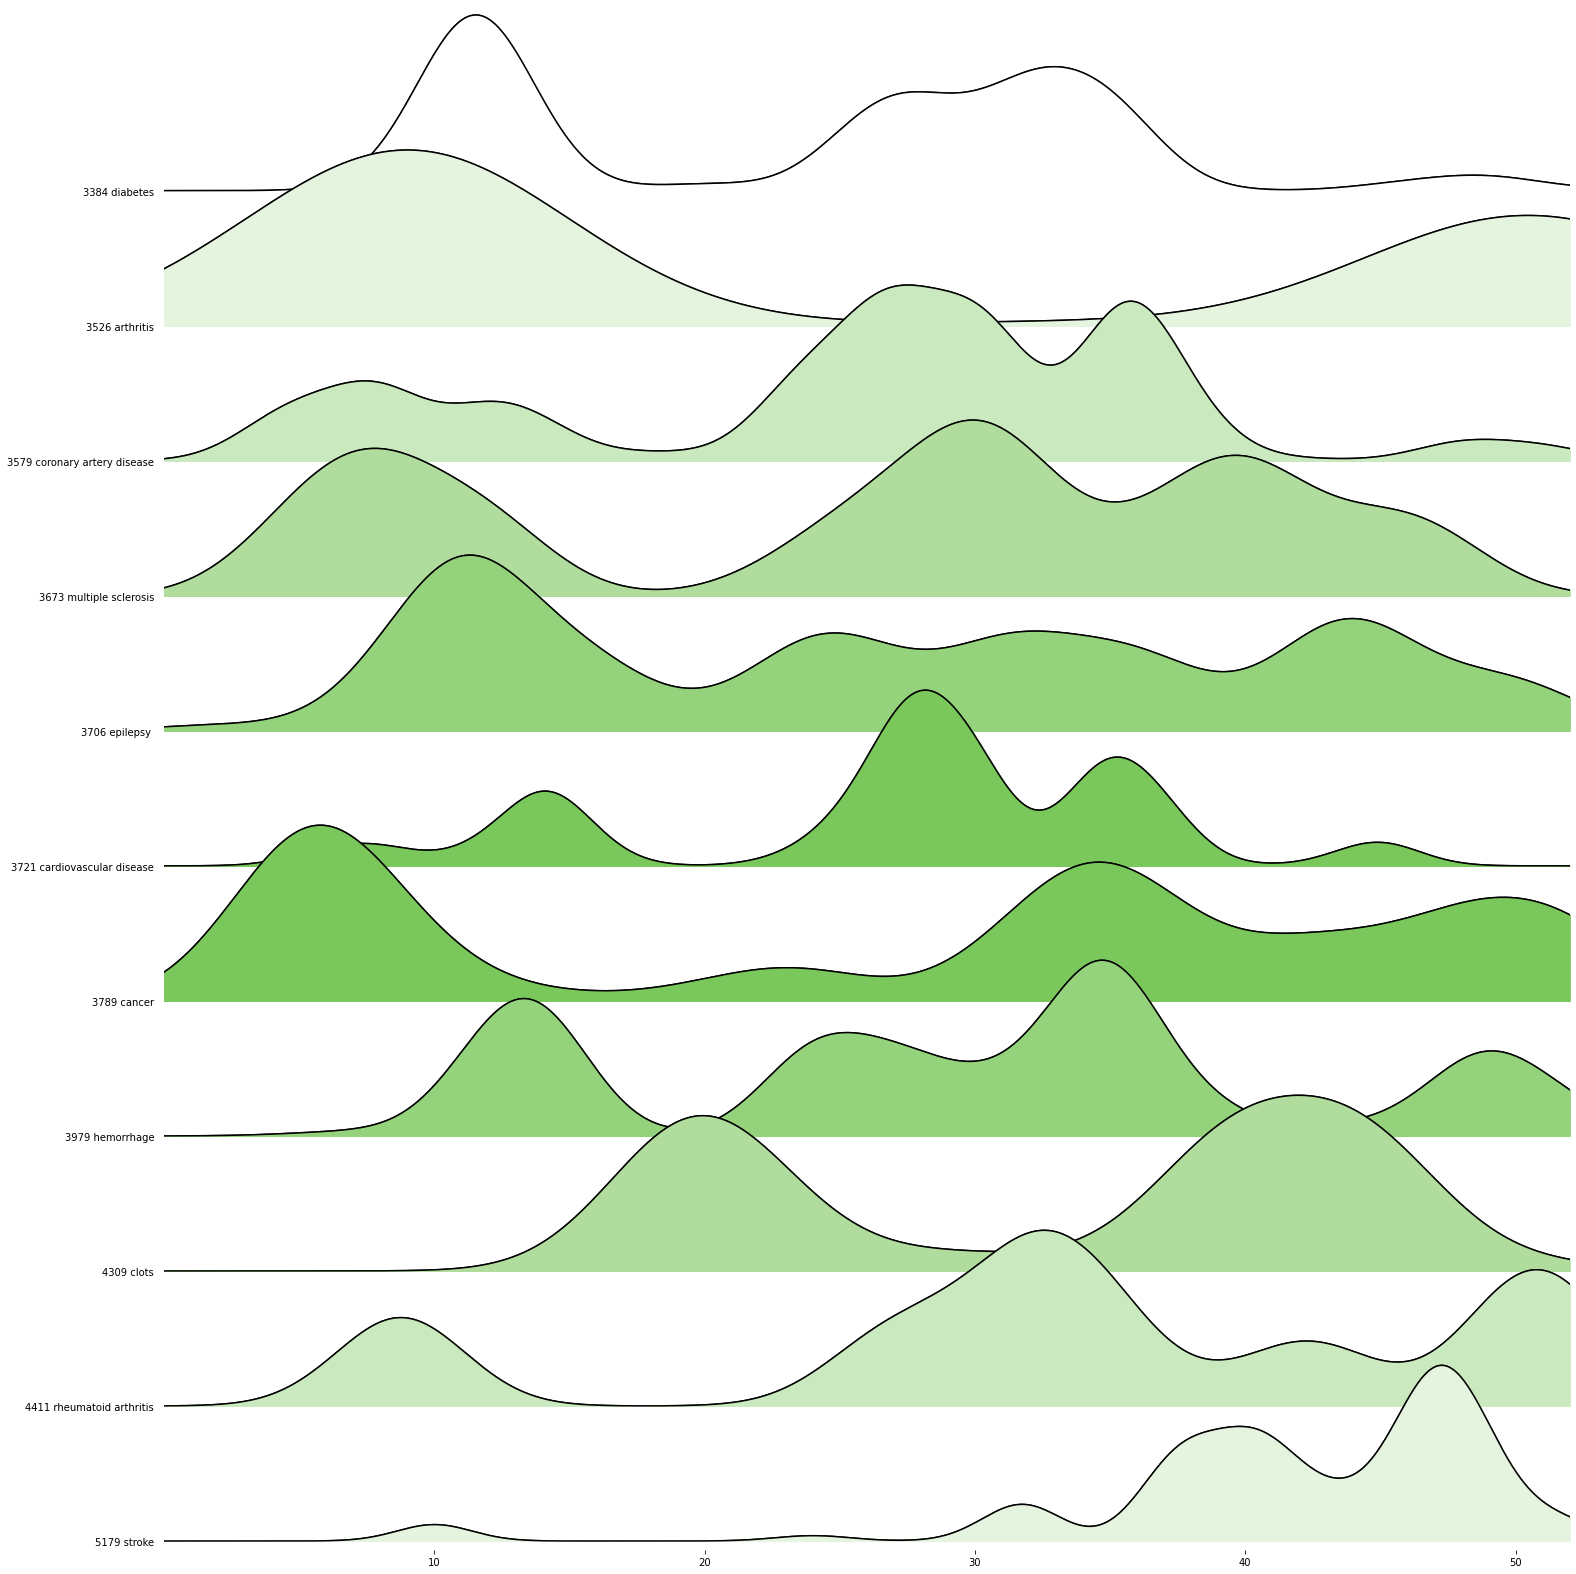

In [ ]:
# request features
df_features = get_trend_frame(topics, '5', 'TX')

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)

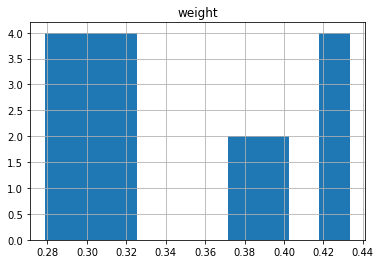

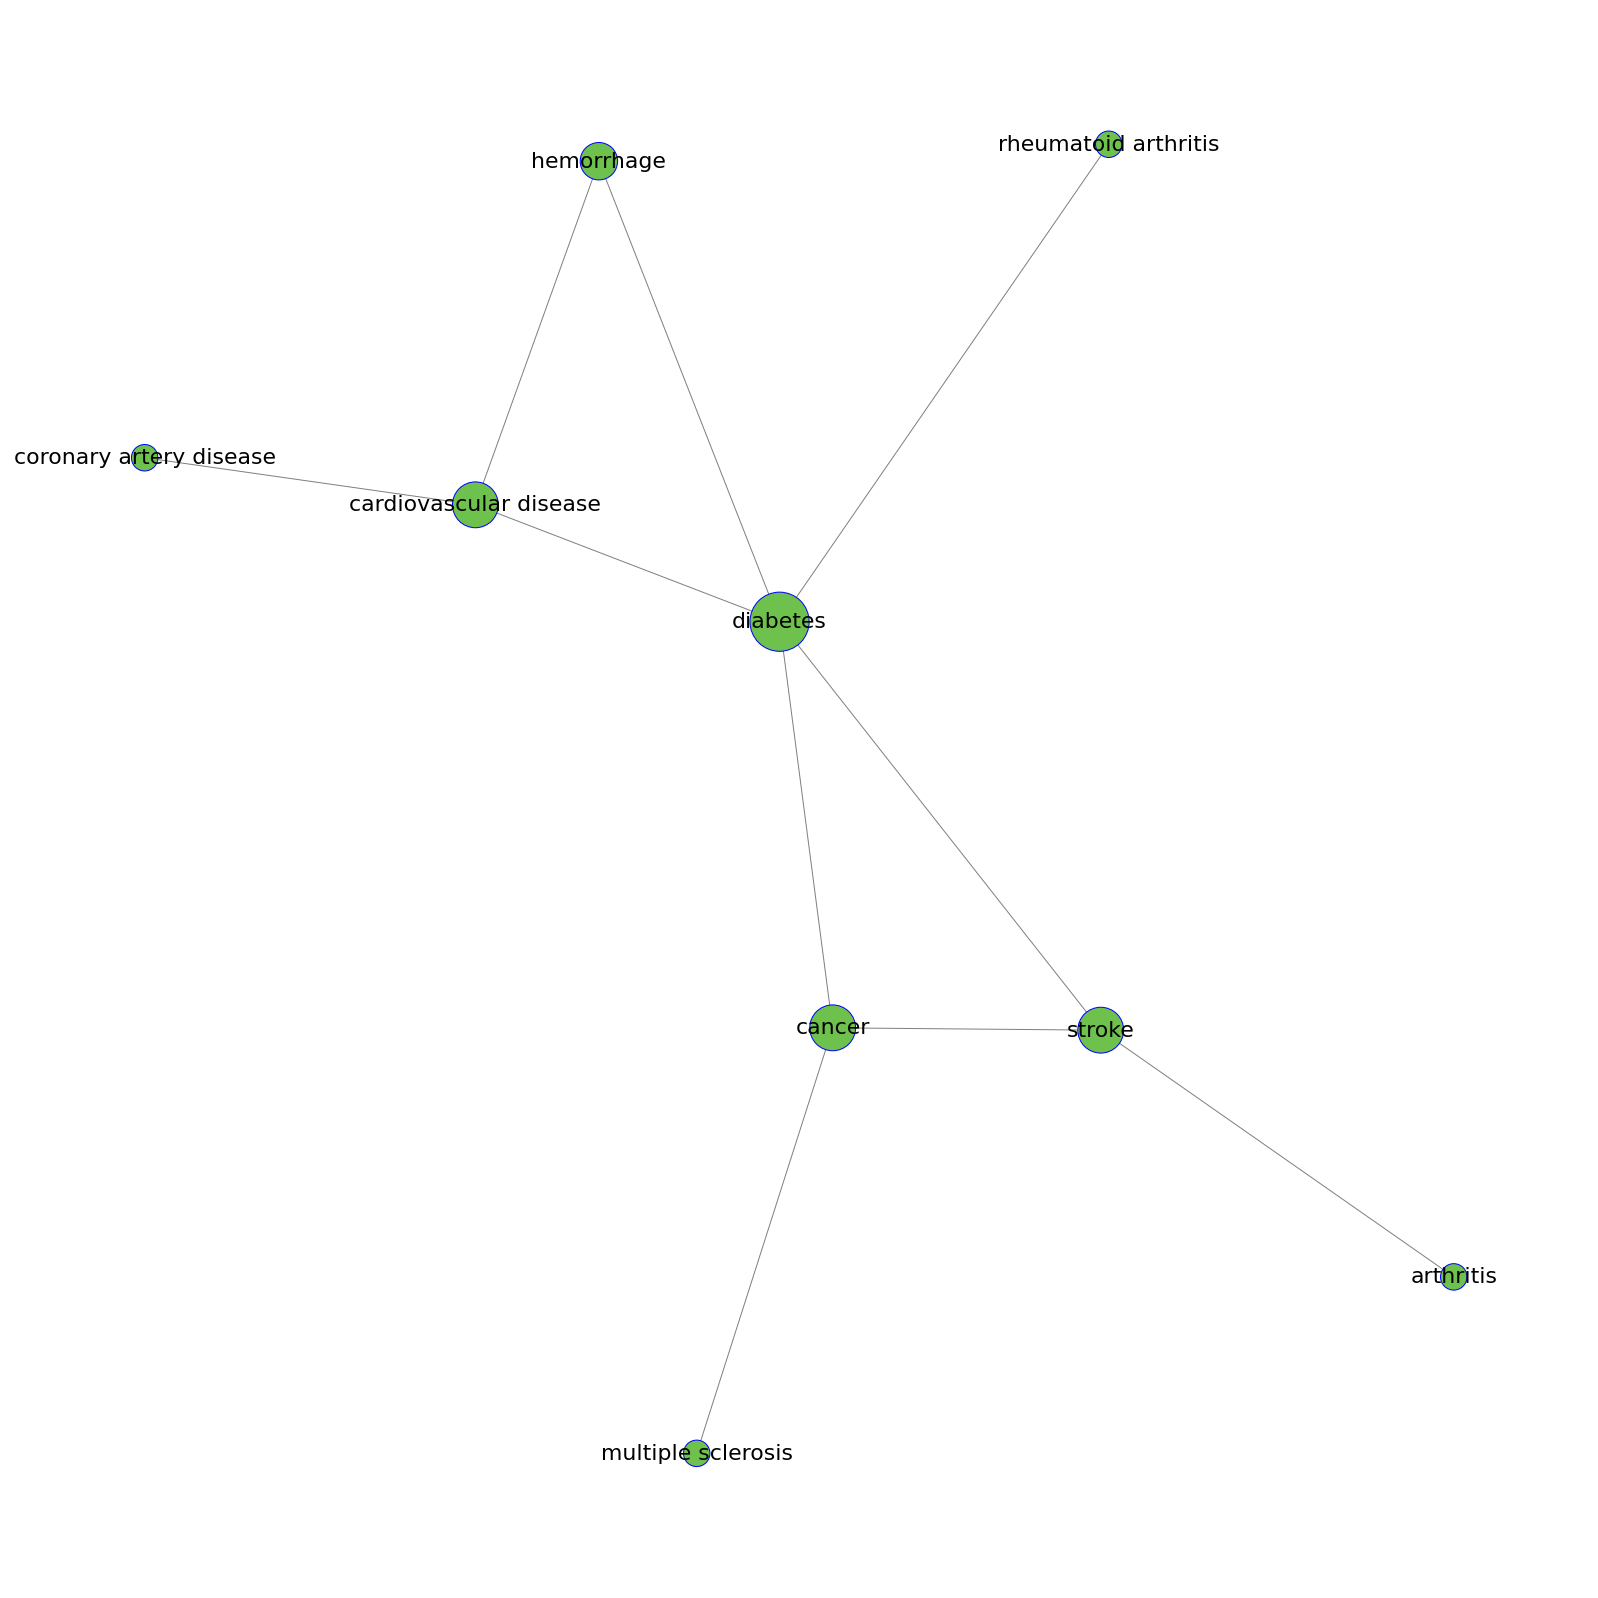

In [ ]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, topics, std_factor)

# display flattened histogram
df_slice.hist()

# build graph
G = build_graph_network(df_slice)
Texas_orginal_G = G

Communities found - 2 

Community 0 - ['cardiovascular disease', 'coronary artery disease', 'diabetes', 'hemorrhage', 'rheumatoid arthritis']
Community 1 - ['arthritis', 'cancer', 'multiple sclerosis', 'stroke']


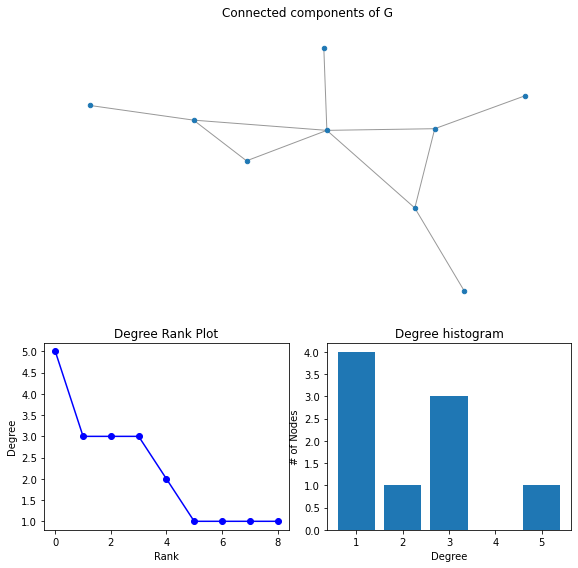

In [ ]:
# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

# print communitied
for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

# demonstrate graph degrees
get_graph_degree(G)

### Texas Generative Wave 1

In [ ]:
# prompt = "list single words that are important aspects of wound care"
# result_length = 100
# inputs = tokenizer(prompt, return_tensors="pt")
# print(inputs)

# print(tokenizer.decode(model.generate(inputs["input_ids"], 
#                        max_length=result_length
#                       )[0]))

# print(tokenizer.decode(model.generate(inputs["input_ids"],
#                        max_length=result_length, 
#                        num_beams=2, 
#                        no_repeat_ngram_size=2,
#                        early_stopping=True
#                       )[0]))

# # Sampling Top-k + Top-p
# print(tokenizer.decode(model.generate(inputs["input_ids"],
#                        max_length=result_length, 
#                        do_sample=True, 
#                        top_k=50, 
#                        top_p=0.9
#                       )[0]))

In [ ]:
# question = 'list single words'
# input_tokens = tokenizer(question, return_tensors="pt").to(0)
# prompt_bloom(question)

# #result = get_bloom_response(input_tokens)
# #print(result)


In [ ]:
# existing community topics
chk_topics = list(df_slice['source'].unique())

# purposed community topics
new_topics = get_related_topics(df_slice
                               , context = 'elderly'
                               , perspective = 'Texas') 
                                 
#new_topics = get_related_topics(df_slice, 'Texas')
print(new_topics)

# new topic list
gen_topics = list(set(swap_tokens(chk_topics, new_topics)))
print(gen_topics)

from the perspetive of Texas resident, list single words diet topics linked to cancer
['-meat, processed foods']
['-meat', 'processed foods']
[]
from the perspetive of Texas resident, list single words behavior topics linked to cancer
['smoking, drinking alcohol excessively']
['smoking', 'drinking alcohol excessively']
['smoking']
from the perspetive of Texas resident, list single words activities topics linked to cancer
["Cancer is a big word. It's scary, too"]
["cancer is a big word. it's scary", 'too']
['smoking']
from the perspetive of Texas resident, list single words holidays topics linked to cancer
['Halloween, Thanksgiving']
['halloween', 'thanksgiving']
['smoking', 'halloween']
from the perspetive of Texas resident, list single words seasonal topics linked to cancer
["1. Fall: pumpkin, leaves changing color; Halloween - costumes and candy corn! 2 Winter Solstice- Christmas time with family gatherings around the tree or fireplace 3 January New Year's Resolutions 4 February Vale

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


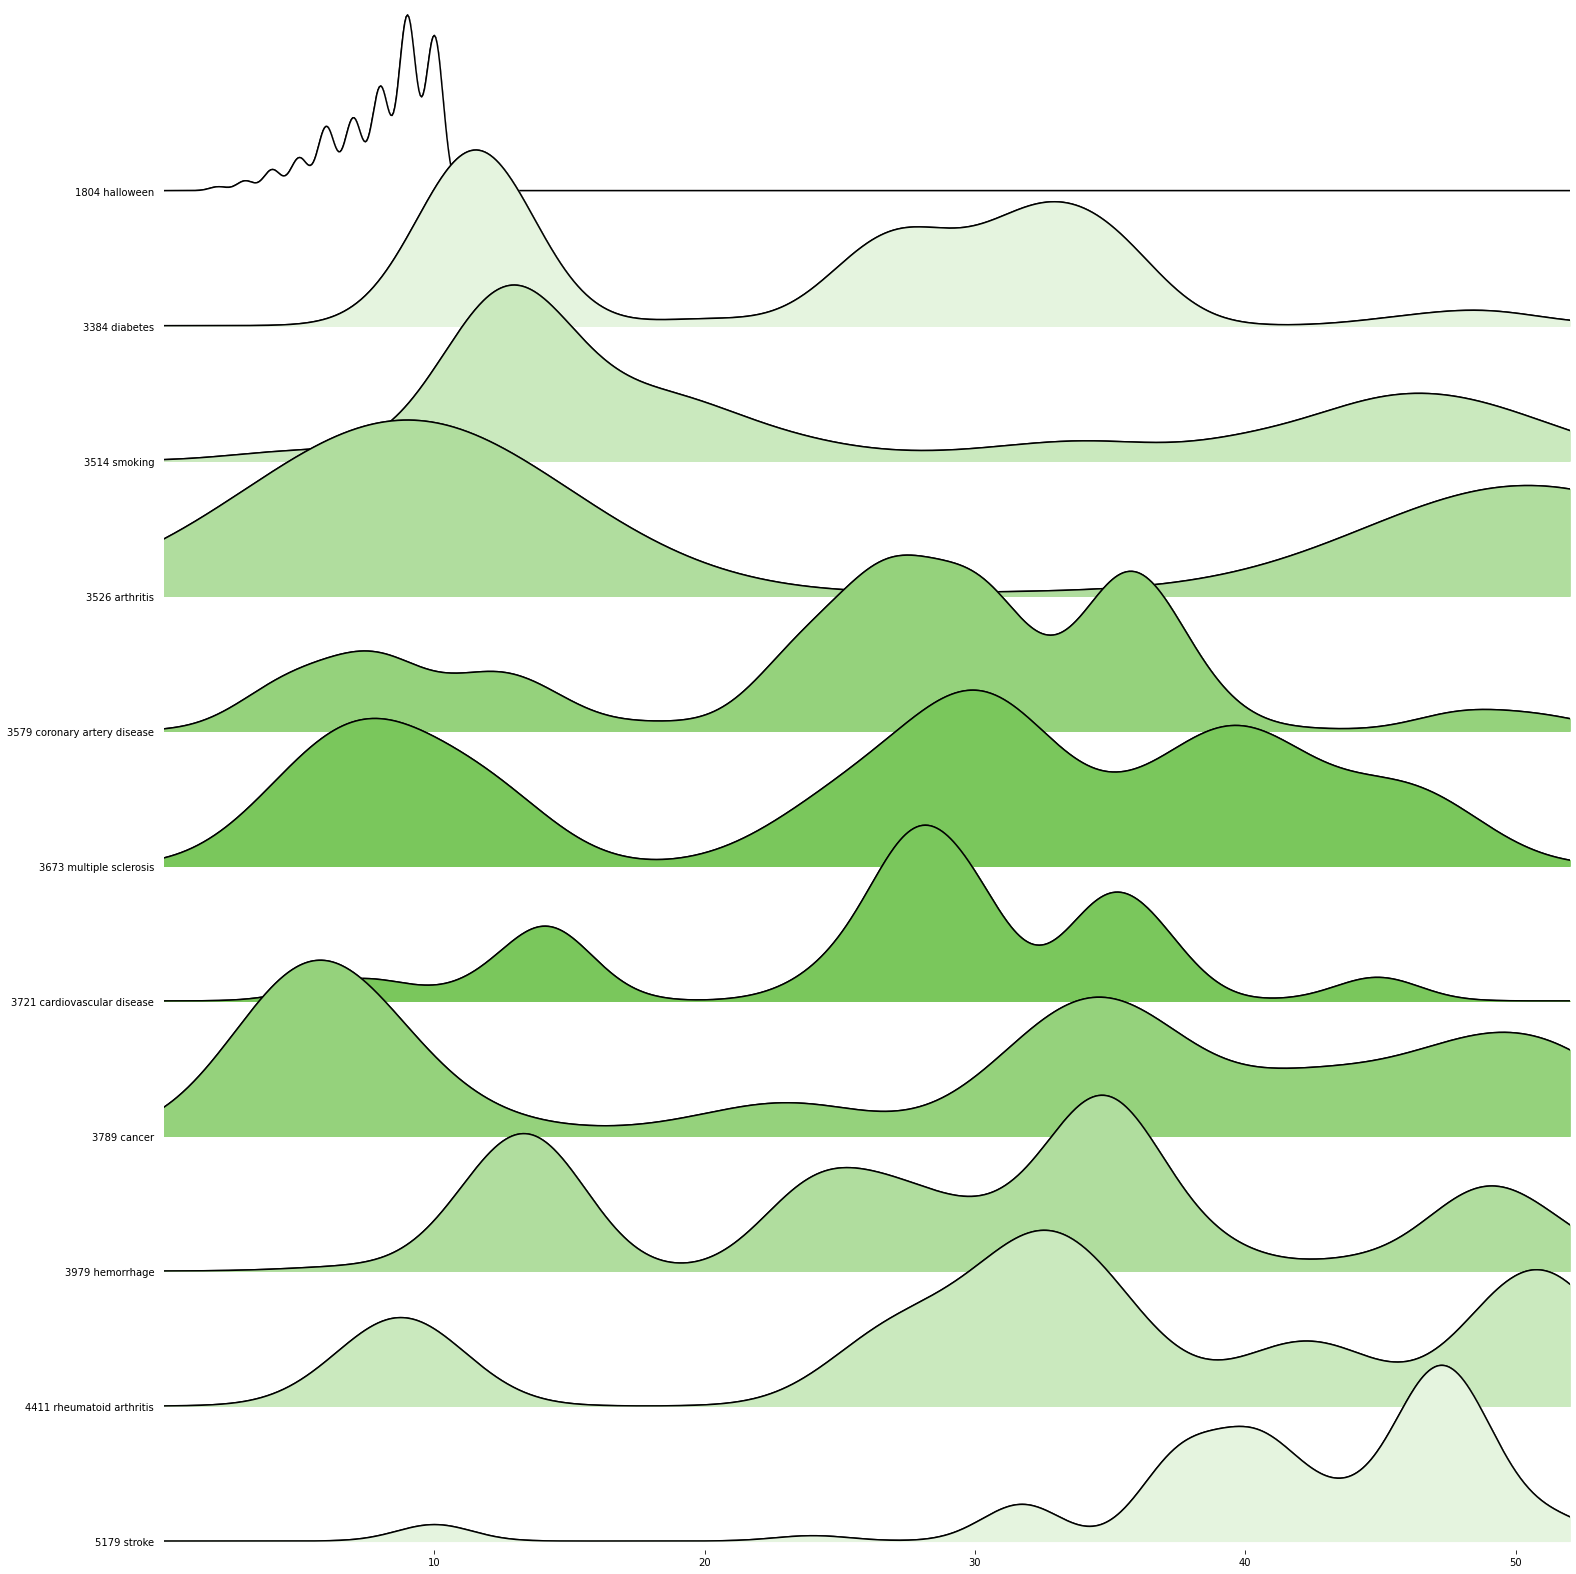

In [ ]:
# request features
df_features = get_trend_frame(gen_topics, '5', 'TX')

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)

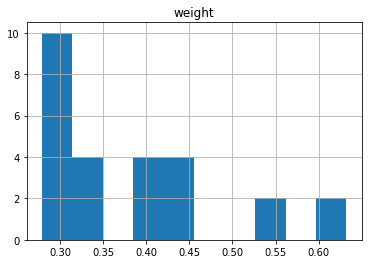

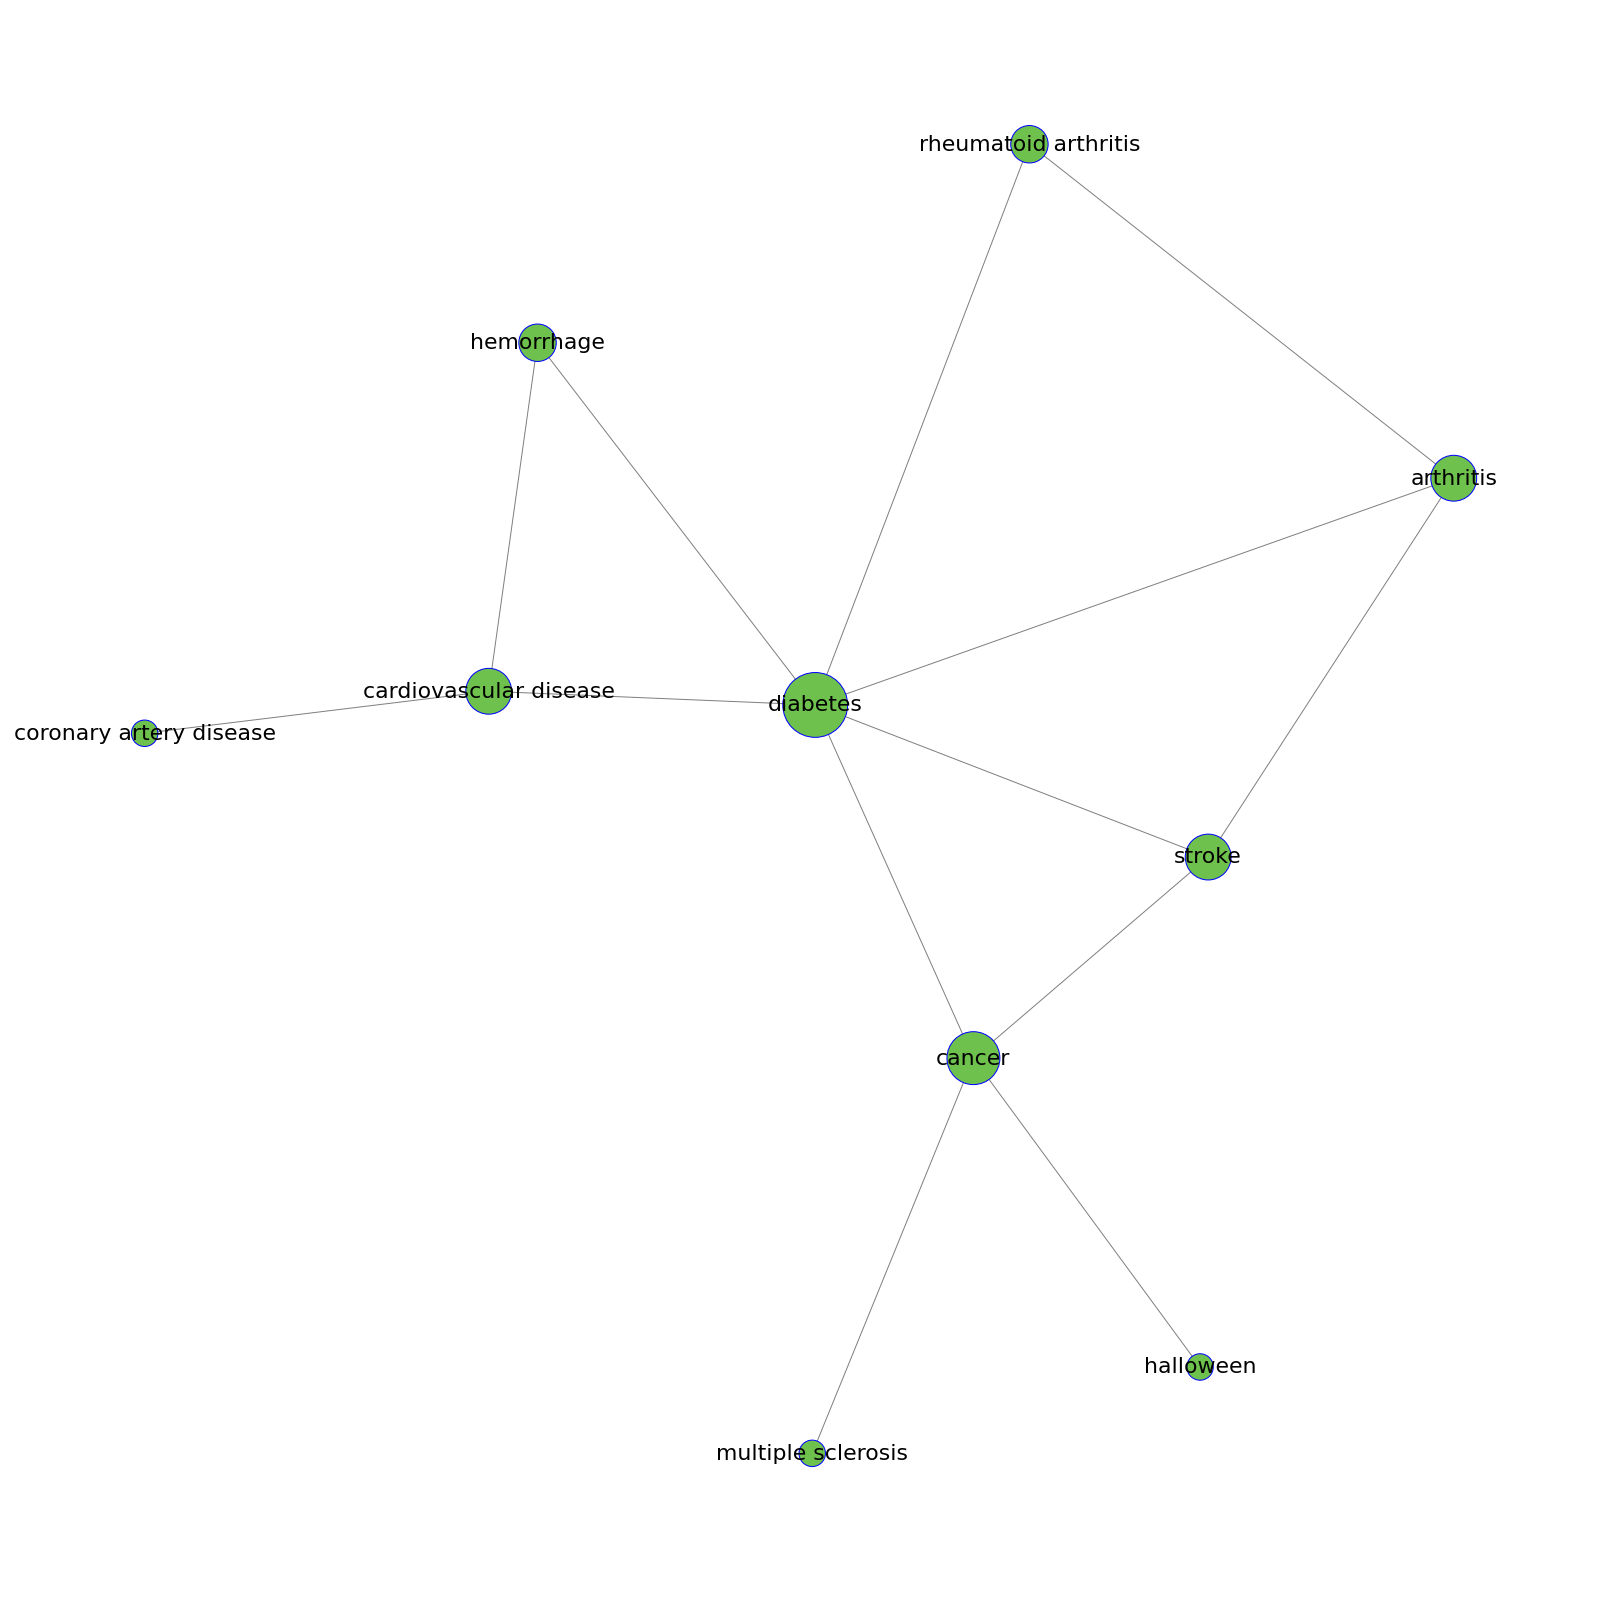

In [ ]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, gen_topics, std_factor)

# reduce to relevant relationships
df_slice = df_slice[(df_slice['weight'] < max_similarity)]
df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()

# build graph
G = build_graph_network(df_slice)
Texas_genwave_1_G = G

Communities found - 3 

Community 0 - ['arthritis', 'diabetes', 'rheumatoid arthritis', 'stroke']
Community 1 - ['cardiovascular disease', 'coronary artery disease', 'hemorrhage']
Community 2 - ['cancer', 'halloween', 'multiple sclerosis']


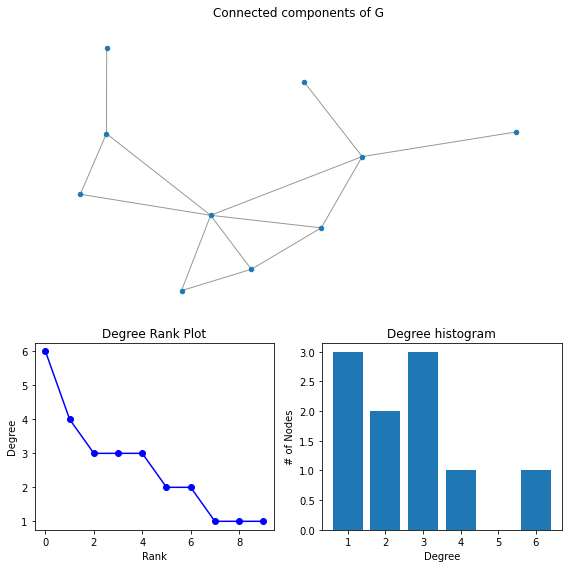

In [ ]:
# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

# print communitied
for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

# demonstrate graph degrees
get_graph_degree(G)

In [ ]:
# TOP 10 Connective Nodes
sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]

[('diabetes', 6),
 ('cancer', 4),
 ('stroke', 3),
 ('cardiovascular disease', 3),
 ('arthritis', 3),
 ('hemorrhage', 2),
 ('rheumatoid arthritis', 2),
 ('halloween', 1),
 ('multiple sclerosis', 1),
 ('coronary artery disease', 1)]

### Texas generative wave 2

In [ ]:
# existing community topics
chk_topics = list(df_slice['source'].unique())

# purposed community topics
# new_topics = get_related_topics(df_slice, 'Texas')
new_topics = get_related_topics(df_slice
                               , context = 'elderly'
                               , perspective = 'Texas') 
print(new_topics)

# new topic list
gen_topics = list(set(swap_tokens(chk_topics, new_topics)))
print(gen_topics)

from the perspetive of Texas resident, list single words diet topics linked to cancer
['-meat, processed foods']
['-meat', 'processed foods']
[]
from the perspetive of Texas resident, list single words behavior topics linked to cancer
['smoking, obesity']
['smoking', 'obesity']
['smoking', 'obesity']
from the perspetive of Texas resident, list single words activities topics linked to cancer
['Cancer is an umbrella term for a group of diseases that affect different parts the body. There are many types cancer, and each one requires its own specific treatment plan']
['cancer is an umbrella term for a group of diseases that affect different parts the body. there are many types cancer', 'and each one requires its own specific treatment plan']
['smoking', 'obesity']
from the perspetive of Texas resident, list single words holidays topics linked to cancer
['Halloween, Thanksgiving']
['halloween', 'thanksgiving']
['smoking', 'obesity', 'halloween']
from the perspetive of Texas resident, list s

hit local max of 11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


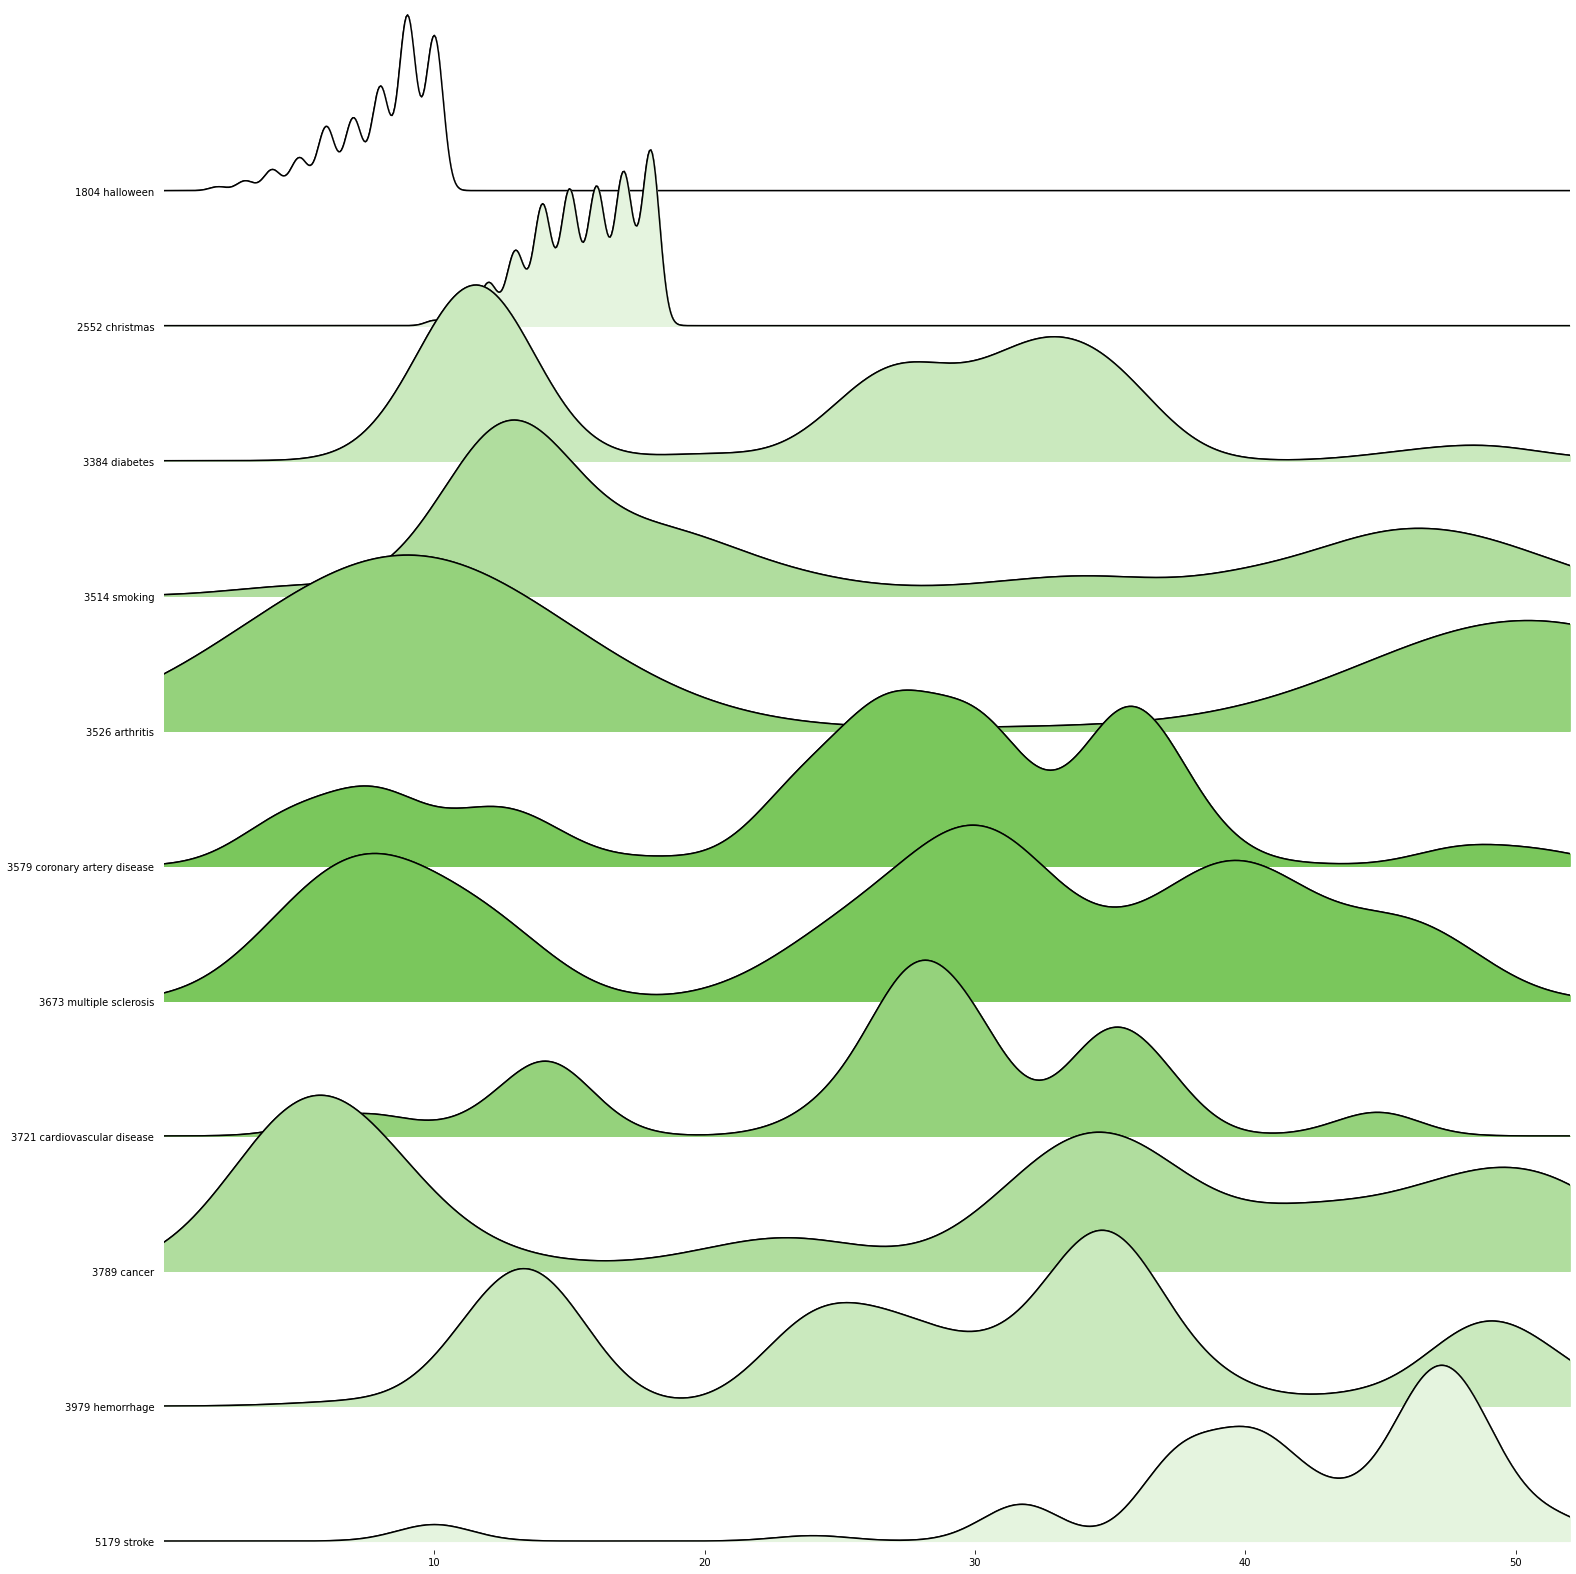

In [ ]:
# request features
df_features = get_trend_frame(gen_topics, '5', 'TX')

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)

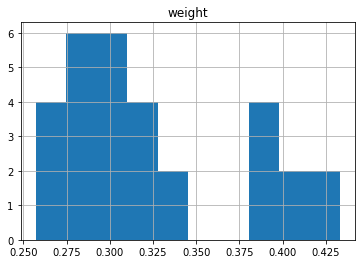

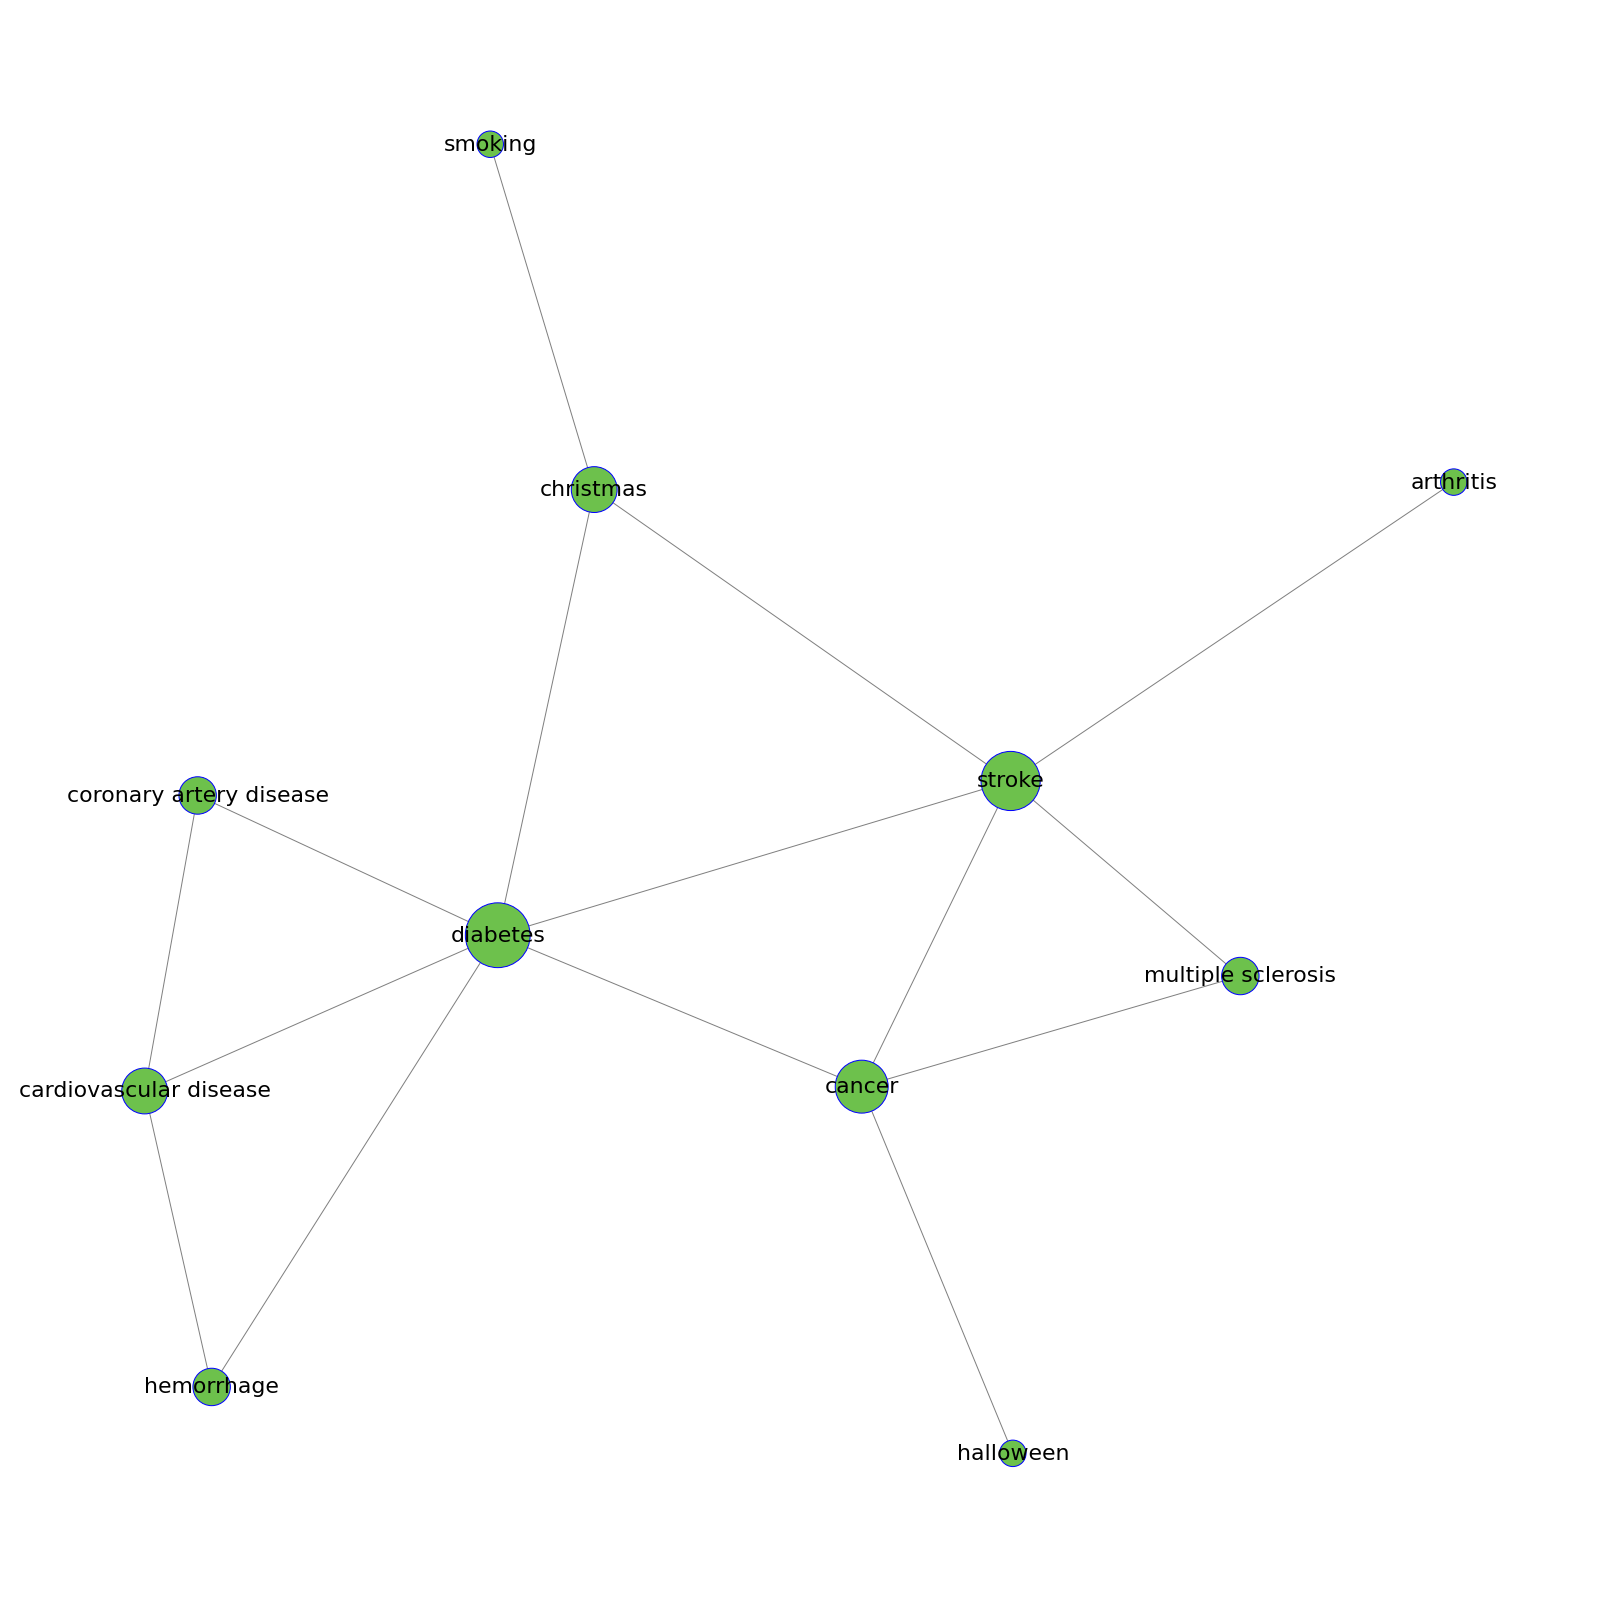

In [ ]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, gen_topics, std_factor*2)

# reduce to relevant relationships
df_slice = df_slice[(df_slice['weight']< max_similarity )]
df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()

# build graph
G = build_graph_network(df_slice)
Texas_genwave_2_G = G

Communities found - 3 

Community 0 - ['arthritis', 'cancer', 'halloween', 'multiple sclerosis', 'stroke']
Community 1 - ['cardiovascular disease', 'coronary artery disease', 'diabetes', 'hemorrhage']
Community 2 - ['christmas', 'smoking']


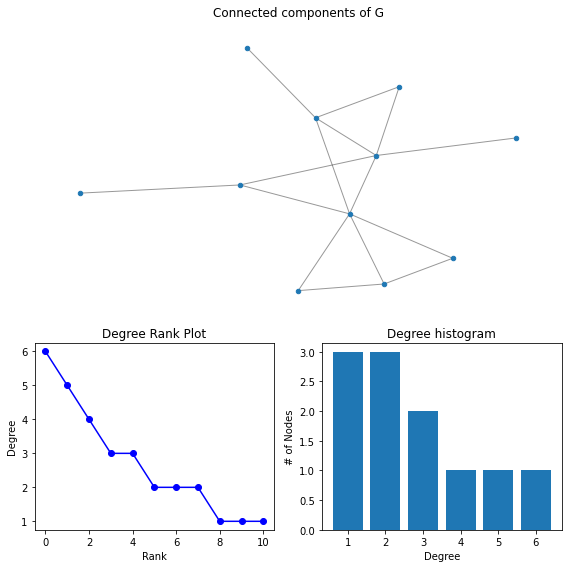

In [ ]:
# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

# print communitied
for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

# demonstrate graph degrees
get_graph_degree(G)

In [ ]:
# TOP 10 Connective Nodes
sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]

[('diabetes', 6),
 ('stroke', 5),
 ('cancer', 4),
 ('christmas', 3),
 ('cardiovascular disease', 3),
 ('multiple sclerosis', 2),
 ('coronary artery disease', 2),
 ('hemorrhage', 2),
 ('smoking', 1),
 ('halloween', 1)]

['Florida-multiple sclerosis', 'Florida-stroke', 'Florida-coronary artery disease', 'Florida-diabetes', 'Florida-cancer', 'Florida-smoking', 'Florida-christmas', 'Florida-cardiovascular disease', 'Florida-halloween', 'Florida-hemorrhage', 'Florida-arthritis', 'Texas-cancer', 'Texas-stroke', 'Texas-diabetes', 'Texas-cardiovascular disease', 'Texas-halloween', 'Texas-hemorrhage', 'Texas-multiple sclerosis', 'Texas-coronary artery disease', 'Texas-arthritis', 'Texas-rheumatoid arthritis']


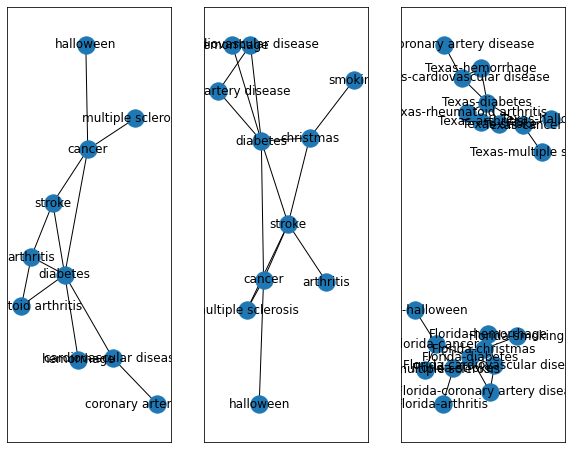

In [ ]:
# visualizations.draw_graph_overlap(G,orginal_G,edge_width=5,node_name_1="Type 2 diabetes",node_name_2="Type 2 diabetes",physics_enabled=False)
_,ax = plt.subplots(1,3, figsize=(10,8))
nx.draw_networkx(Texas_genwave_1_G, ax=ax[0])
nx.draw_networkx(Texas_genwave_2_G, ax=ax[1])
#U = nx.union(Texas_genwave_2_G, Texas_genwave_1_G, rename=('Florida-','Texas-'))
#U = nx.union(G, orginal_G, rename=('T','T'))
#U = nx.disjoint_union(G, orginal_G)
nx.draw_networkx(U, ax=ax[2])
print(U.nodes())

In [ ]:
!pip install graphdatascience

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 3.5 MB/s 
     |████████████████████████████████| 95 kB 3.4 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.5-py3-none-any.whl size=123291 sha256=5a3dbdedfbecb024a2a24982ea4f0a6ac78f43d8323ebe8f10cae95cbd0d9822
  Stored in directory: /root/.cache/pip/wheels/73/62/2d/6532ffe9b1fdc65f04e7461279cda78fccaa67cf3c706e6e3d
Successfully built neo4j


In [ ]:
from graphdatascience import GraphDataScience 
from neo4j import GraphDatabase

In [ ]:
AURA_CONNECTION_URI = "neo4j+s://6e96e772.databases.neo4j.io"
AURA_USERNAME = "neo4j"
AURA_PASSWORD = open('neo4j_key.txt').read()

# Client instantiation
gds = GraphDataScience(
    AURA_CONNECTION_URI,
    auth=(AURA_USERNAME, AURA_PASSWORD),
    aura_ds=True
)

In [ ]:
print(gds.version())

2.1.8


In [ ]:
results = gds.list()

# Print the result (a Pandas DataFrame)
# print(results[:5])
# print(results[:5].to_string())


In [ ]:
# Print the result (a Pandas DataFrame) as a prettified JSON string
# print(results[:5].to_json(orient="table", indent=2))


In [ ]:
# List all in-memory graphs
all_graphs = gds.graph.list()

print(all_graphs)

Empty DataFrame
Columns: [degreeDistribution, graphName, database, memoryUsage, sizeInBytes, nodeCount, relationshipCount, configuration, density, creationTime, modificationTime, schema]
Index: []


In [ ]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response


conn = Neo4jConnection(uri=AURA_CONNECTION_URI, 
                       user=AURA_USERNAME,              
                       pwd=AURA_PASSWORD)

In [ ]:
# conn.query('CREATE CONSTRAINT papers IF NOT EXISTS ON (p:Paper)     ASSERT p.id IS UNIQUE')
# conn.query('CREATE CONSTRAINT authors IF NOT EXISTS ON (a:Author) ASSERT a.name IS UNIQUE')
# conn.query('CREATE CONSTRAINT categories IF NOT EXISTS ON (c:Category) ASSERT c.category IS UNIQUE')

In [182]:
def insert_data(query, rows, batch_size = 10000):

    # Function to handle the updating the Neo4j database in batch mode.
    total = 0
    batch = 0
    start = time.time()
    result = None
    
    # return cypher query for learning opportunity
    if cypher_echo:
      print(query)
    
    # batch processing
    while batch * batch_size < len(rows):

        res = conn.query(query, 
                         parameters = {'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        
        total += res[0]['total']
        batch += 1
        result = {"total":total, 
                  "batches":batch, 
                  "time":time.time()-start}
        
    return result

In [183]:
def add_nodes(categories, node_label):
    # Adds category nodes to the Neo4j graph.
    query = '''
            UNWIND $rows AS row
            MERGE (c:''' + node_label + ''' {''' + node_label + ''': row.''' + node_label + '''})
            RETURN count(*) as total
            '''
    return conn.query(query, parameters = {'rows':categories.to_dict('records')})

In [184]:
def add_edges(rows, left_node, right_node, batch_size=5000):

   query = '''
   UNWIND $rows as row
   MATCH (p:''' + left_node + ''' {''' + left_node + ''':row.''' + left_node + '''}) 
 
   WITH row, p

    UNWIND row.''' + right_node + ''' AS ''' + right_node + '''
    MATCH (c:''' + right_node + ''' {''' + right_node + ''': ''' + right_node + '''})
    MERGE (p)-[:IN_CATEGORY]->(c)
    RETURN count(distinct p) as total
   '''
 
   return insert_data(query, rows, batch_size)

In [179]:
# rough cat 1
label_col = 'source'
categories = pandas.DataFrame(df_slice[label_col])

categories.rename(columns={label_col:label_col},
                  inplace=True)

categories = categories.explode(label_col) \
                       .drop_duplicates(subset=[label_col])

#add_categories(categories)
add_nodes(categories, label_col)


# rough cat 2
label_col_left = 'source'
label_col_right = 'target'
categories = pandas.DataFrame(df_slice[[label_col_left, label_col_right]])

#add_categories(categories)
add_nodes(categories, label_col)
add_edges(categories, label_col_left, label_col_right)


   UNWIND $rows as row
   MATCH (p:source {source:row.source}) 
 
   WITH row, p

    UNWIND row.target AS target
    MATCH (c:target {target: target})
    MERGE (p)-[:IN_CATEGORY]->(c)
    RETURN count(distinct p) as total
   
{'total': 11, 'batches': 1, 'time': 0.28959202766418457}


{'total': 11, 'batches': 1, 'time': 0.28959202766418457}

In [ ]:
df_slice['source'].unique()

array(['multiple sclerosis', 'stroke', 'coronary artery disease',
       'diabetes', 'cancer', 'smoking', 'christmas',
       'cardiovascular disease', 'halloween', 'hemorrhage', 'arthritis'],
      dtype=object)

In [ ]:
categories

,0
0,multiple sclerosis
1,stroke
2,coronary artery disease
3,diabetes
4,cancer
5,smoking
6,christmas
7,cardiovascular disease
8,halloween
9,hemorrhage
